<a href="https://colab.research.google.com/github/TimilsinaSushil/Thesis/blob/main/QC5_4500(Improving_K_fold_validation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# !pip install torch==1.3.1+cpu -f https://download.pytorch.org/whl/torch_stable.html
# !pip install inltk
# !pip install nepali-stemmer
from inltk.inltk import setup
from inltk.inltk import tokenize
from inltk.inltk import get_embedding_vectors
from nepali_stemmer.stemmer import NepStemmer
# setup('ne')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [77]:
# from google.colab import files
# uploaded = files.upload()
df = pd.read_csv('QSN.csv')

['temporal' 'location' 'numerical' 'person' 'organization' 'explanation' 'miscellaneous']


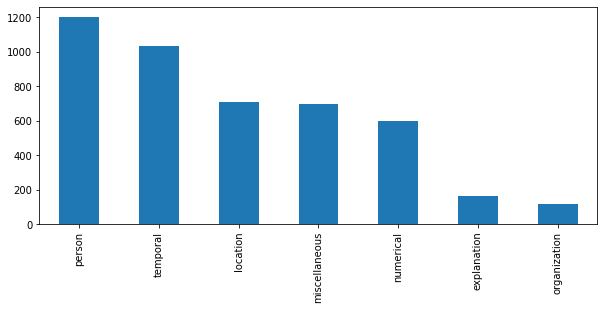

In [78]:
#coarse type filtering
df=df[df['CoarseType'].isin(['location','temporal','numerical','person','organization','explanation','miscellaneous'])]
coarse_type=df['CoarseType'].unique()
# print(coarse_type)
print(coarse_type)
plt.figure(figsize=(10,4))
df.CoarseType.value_counts().plot(kind='bar');


**Text Preprocessig**

In [79]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [80]:
#removing text inside brackets and quotes
import re
def removeTextInsideQuotesAndBrackets(text):
  text=re.sub("[\(\[].*?[\)\]]", "", text)
  text=re.sub("\'.*?\'","",text)
  text=re.sub('\".*?\"',"",text)
  return text

In [81]:
def removeKo(text):
  words= text.split()
  text=[]
  for word in words:
    length=len(word)
    if(length > 2):
      if(word[-2]=='क' and word[-1]=='ो'):
        if(word!='कसको'):
          word= word[:length-2]
    text.append(word)
  text=' '.join([word for word in text])
  # print(text)
  return text




In [82]:
def preprocessing(questions):
  questions=questions.apply(removeTextInsideQuotesAndBrackets)
  # questions = questions.apply(removeKo)
  #tokenization
  questions= questions.apply(lambda x: tokenize(x,'ne'))
  #removing duplicates
  questions= questions.apply(lambda x: list(dict.fromkeys(x)))
  
  questions=questions.apply(lambda x: ' '.join(x).replace('▁','').split())
  questions=questions.apply(lambda x: ' '.join(x))

  #removing numbers
  questios=questions.apply(lambda x: ''.join(c for c in x if not c.isdigit()))
  #removing punctuation
  punctuation=['!','"','#','$','&',"'",'(',')','*','+',',','-','.','/',':',';','<','=','>','?','@','[',"]",'^','_','`','{','|','}','~']
  questions = questions.apply(lambda x: ''.join(c for c in x if c not in punctuation))

  #removing stopwords
  WHWORDS = ['कुन','कहिले','के','कति','को','कसले','कहाँ','कसलाई','कसको','कस्तो','कति','कसरी','किन','कता']
  STOPWORDS = stopwords.words('nepali')
  # Removig WH words from STOPWORDS
  for word in WHWORDS:
    if word in STOPWORDS: STOPWORDS.remove(word)

  STOPWORDS=set(STOPWORDS)
  def clean_text(text):
      text=' '.join([word for word in text.split() if word not in STOPWORDS]) # delete stopwords from text
      return text
  questions = questions.apply(clean_text)
  return questions



In [ ]:
#stemmig
# nepstem = NepStemmer()
# df['Questions'] = df['Questions'].apply(nepstem.stem)
# df.head(10)

In [83]:
df['Questions'] = preprocessing(df['Questions'])

df.head()



,Questions,Answer,CoarseType,FineType,WhWord,Domain
0,नेपाली क्रिकेट टिम क्याप्टेन ज्ञानेन्द्र मल्ल ...,वि.सं. २०७६ कार्तिक १३,temporal,date,कहिले,Sports
1,फ्रान्स को लियोन सम्पन्न महिला विश्वकप फुटबल २...,अमेरिका,location,country,कसले,Sports
2,विश्व शान्ति सू चा ंक २०१९ नेपाल कति औ स्थानमा,७६ औ स्थानमा,numerical,rank,कति,Miscellaneous
3,फलफूल को बोट रु दश नोट कार्यक्रमको सुरुवात कुन...,"इच्छाकामना गाउँपालिका, चितवन",location,city,कुन,Politics
4,माथिल्लो त्रिशुली थ्री जल विध ुत आयोजना को विध...,वि.स. २०७६ जेठ ०२,temporal,date,कहिले,Miscellaneous


**Decleration**

In [84]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier;
from sklearn.linear_model import LogisticRegression
TEST_SIZE=0.30
from sklearn.model_selection import StratifiedKFold
N_FOLD = 10

***K Fold Coarse Model***

In [85]:
def kFoldCoarseModel(algorithm):
  from sklearn.metrics import confusion_matrix
  import random 

  X = df.Questions
  y = df.CoarseType

  # Splitting test set
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20) 

  metrics = []
  skf= StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=1)
  X=np.array(X_train)
  y=np.array(y_train)

 # Defining Model
  if(algorithm=='nb'):
    model = Pipeline([('vect', CountVectorizer()),
              ('tfidf', TfidfTransformer()),
              ('clf', MultinomialNB()),
              ]) 
  elif(algorithm=="svm"):
    model = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', OneVsRestClassifier(SVC(C=1, kernel='sigmoid'))),    #Non linear svm
              ])
    
    #gaussian
    #sigmoid
  #model defination finished
  

  # K fold cross validation
  for train_index, validation_index in skf.split(X, y):
      print("TRAIN:", train_index, "VALIDATION:", validation_index)
      X_train, X_validation = X[train_index], X[validation_index]
      y_train, y_validation = y[train_index], y[validation_index]
  #   # train the model
      model.fit(X_train,y_train)
  #   # validate the model 
      y_pred_class_for_validation = model.predict(X_validation)
      metrics.append(accuracy_score(y_validation, y_pred_class_for_validation))
      # print(classification_report(y_test, y_pred_class,target_names=coarse_type))
      

  


  metrics = np.array(metrics)
  print('Validation Accuracy for each Iteration',metrics)
  print('Mean accuracy for validation set: ', np.mean(metrics, axis=0))
  print('Std for accuracy: ', np.std(metrics, axis=0))
  print('---------------------------------------------------------------------------------')

  y_pred = model.predict(X_test)

  test_accuracy = accuracy_score(y_pred, y_test)
  print('Test Accuracy : %s' % test_accuracy)
  print(classification_report(y_test, y_pred,target_names=coarse_type))

  cf_matrix = confusion_matrix(y_test, y_pred, labels=coarse_type)
  # print(cf_matrix)

  import seaborn as sns
  plt.figure(figsize=(8,7))
  actual_data= ['temporal' 'location' 'numerical' 'person' 'organization' 'explanation' 'miscellaneous']
  predicted_data= ['temporal' 'location' 'numerical' 'person' 'organization' 'explanation' 'miscellaneous']
  cm = confusion_matrix(actual_data, predicted_data)
  ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')
  ax.set_title('Confusion Matrix')
  ax.set_xlabel('Predicted Intent')
  ax.set_ylabel('Actual Intent')
  ax.xaxis.set_ticklabels(['TEM','LOC','NUM','PER','ORG','EXP','MISC'])
  ax.yaxis.set_ticklabels(['TEM','LOC','NUM','PER','ORG','EXP','MISC'])
  plt.show()
  
  return model


TRAIN: [   0    1    2    3 ... 3606 3607 3609 3612] VALIDATION: [   6    7   35   36 ... 3602 3608 3610 3611]
TRAIN: [   0    1    2    3 ... 3609 3610 3611 3612] VALIDATION: [  13   15   23   28 ... 3587 3588 3591 3604]
TRAIN: [   0    1    2    3 ... 3609 3610 3611 3612] VALIDATION: [   9   33   43   71 ... 3564 3567 3580 3605]
TRAIN: [   0    1    2    3 ... 3609 3610 3611 3612] VALIDATION: [   4   24   34   39 ... 3555 3557 3568 3581]
TRAIN: [   1    2    3    4 ... 3609 3610 3611 3612] VALIDATION: [   0    5   10   20 ... 3573 3586 3592 3594]
TRAIN: [   0    1    2    3 ... 3609 3610 3611 3612] VALIDATION: [  21   53   59   68 ... 3544 3574 3579 3585]
TRAIN: [   0    1    3    4 ... 3608 3610 3611 3612] VALIDATION: [   2    8   17   19 ... 3582 3597 3598 3609]
TRAIN: [   0    1    2    3 ... 3609 3610 3611 3612] VALIDATION: [  12   22   30   58 ... 3572 3583 3584 3590]
TRAIN: [   0    2    3    4 ... 3608 3609 3610 3611] VALIDATION: [   1   16   18   25 ... 3600 3603 3607 3612]
T

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


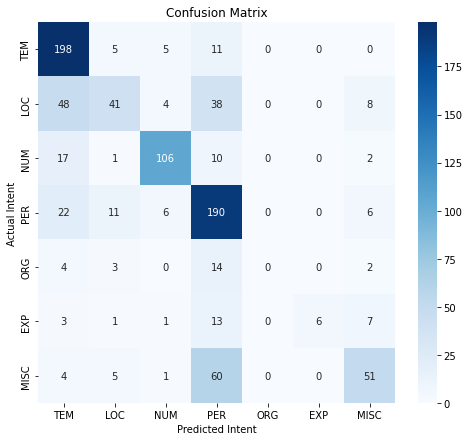

In [73]:
k_fold_nb_model= kFoldCoarseModel('nb')

In [ ]:
k_fold_svm_model= kFoldCoarseModel('svm')

***Train Test split coarse model***

In [38]:
def coarseModel(algorithm):
  X = df.Questions
  y = df.CoarseType

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state = 42) 

  if(algorithm=='nb'):
    model = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ]) 
  elif(algorithm=='sgd'):
    model = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None, shuffle=True)), #Equivalent to linear svm
               ])
  elif(algorithm=="svm"):
    model = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', OneVsRestClassifier(SVC(C=1, kernel='sigmoid'))),    #Non linear svm
               ])
    # model = Pipeline([('vect', CountVectorizer()),
    #           ('tfidf', TfidfTransformer()),
    #           ('clf', LinearSVC(loss='hinge', penalty='l2', random_state=None, max_iter=5,tol=0.0001)), #Linear  svm
    #           ])
  else:
    model = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
  

  model.fit(X_train, y_train)
  # %time

  y_pred = model.predict(X_test)

  model_accuracy = accuracy_score(y_pred, y_test)
  print('Accuracy : %s' % model_accuracy)
  print(classification_report(y_test, y_pred,target_names=coarse_type))
  return model




In [ ]:
nb_model=coarseModel('nb');

In [ ]:
sgd_model=coarseModel('sgd')

In [ ]:
svm_model=coarseModel('svm')

In [ ]:
# logreg_model=coarseModel('logreg')

**Predictions**

In [86]:
unseen_questions=[["सन् २०२० मार्चमा प्रदान गरिएको इन्टरनेसनल कम्युनिकेसन अवार्ड बाट सम्मानित व्यत्तित्व को हनुहुन्छ ? "],["नेपाल न्यून आय भएका मुलुकबाट न्यून मध्यम आय भएका मुलुकको सूचीमा कहिले स्तरोन्नति भएको हो ? "],
                      ["वि.सं. २०७७ असार २३ सरकारले नेपाल प्रहरी महानिरीक्षक (आईजीपी) मा कसलाई नियुक्त गर्यो ?"],["हाल रेडियो नेपालबाट कति भाषामा समाचार प्रसारण हुने गर्छ ?"],
                      ["समाजसेवी तथा शिक्षाविद् अङ्गुरबाबा जोशीको निधन कहिले भएको हो ?"],["सन् २०२० जुनमा सुरक्षा परिषदको अस्थायी सदस्यमा निर्वाचित हुन सफल राष्ट्र कुन कुन हुन ?"],
                      ["'एक वडा एक व्यायामशाला' निमाणको योजना अघि बढाउने स्थानीय तह कुन हो ?"],["बालबालिकाको क्षेत्रमा काम गर्ने अन्तर्राष्ट्रिय संस्था किवानिज इन्टरनेसनलको एसिया प्यासिफिक सम्मेलन हालै कहाँ सम्पन्न भयो ?"],
                      ["लोकसेवा आयोग विधेयक प्रतिनिधिसभाबाट कहिले पारित भएको हो ?"],["नेपालमा कृषक परिचयपत्र वितरण गर्ने कार्य कुन जिल्लाबाट सुरु गरिएको हो ?"],
                      ["विश्व बैंकद्वारा विसं २०७६ कात्तिक ७ मा सार्वजनिक डुइङ बिजनेस प्रतिवेदन २०२० अनुसार नेपाल कतिऔं स्थानमा रहेको छ ?"],['नेपाली पोर्टको शुभारम्भ कहिले भएको हो ?'],
                      ["सन्  २०१९/२० को विस्डन क्रिकेटर अफ द इयरको उपाधि जित्ने क्रिकेटर को हुन ?"],['सबै जिल्लामा स्वास्थ्य विमा सेवा लागु गर्ने पहिलो प्रदेश कुन हो ?']]
dfq=pd.DataFrame(unseen_questions,columns=['questions'])

dfq['questions']= preprocessing(dfq['questions'])
validation_questions=dfq['questions'].to_numpy()


# print("Naive Bayes Classifier \n")
# for question in validation_questions:
#   question=[question]
#   test_pred= nb_model.predict(question)
#   print(question[0] +' : ' + test_pred[0])
# print('\n')


# print("SGDC Classifier \n")
# for question in validation_questions:
#   test_pred= sgd_model.predict(question)
#   print(question[0] +' : ' + test_pred[0])
# print('\n')

print("Support Vector Machine(Train/Test split) \n")
for question in validation_questions:
  question=[question]
  test_pred= svm_model.predict(question)
  print(question[0] +' : ' + test_pred[0])
print('\n')


print("Support Vector Machine(K fold cross validation) \n")
for question in validation_questions:
  question=[question]
  test_pred= k_fold_svm_model.predict(question)
  print(question[0] +' : ' + test_pred[0])
print('\n')

# print("Logistic Regression \n")
# for question in validation_questions:
#   test_pred= logreg_model.predict(question)
#   print(question[0] +' : ' + test_pred[0])


Support Vector Machine(Train/Test split) 

सन् २०२० मार्च प्रदान गरिएको इन्टरनेसनल कम्युन िक ेसन अवार्ड बाट सम्मानित व्य त्ति त्व को हन ुहुन्छ : miscellaneous
नेपाल न्यून आय भएका मुलुक बाट मध्यम मुलुकको सूची कहिले स्तर ो न्न ति : temporal
वि सं २०७७ असार २३ सरकार नेपाल प्रहरी महानिरीक्षक कस नियुक्त गर्यो : person
हाल रेडियो नेपाल बाट कति भाषामा समाचार प्रसारण : numerical
समाजसेवी शिक्षा विद् अङ्ग ुर बाबा जोशी को निधन कहिले : temporal
सन् २०२० सुरक्षा परिषद को अस्थायी सदस्य निर्वाचित सफल राष्ट्र कुन : person
ण को योजना अघि बढाउने स्थानीय तह कुन : location
बालबालिका को क्षेत्रमा काम अन्तर्राष्ट्रिय संस्था वा निज इन्टरनेसनल एसिया प्यास िफ िक सम्मेलन हालै कहाँ सम्पन्न भयो : temporal
लोक सेवा आयोग विधेयक प्रतिनिधिसभा बाट कहिले पारित : temporal
नेपालमा कृषक परिचय पत्र वितरण कार्य कुन जिल्लाबाट सुरु गरिएको : temporal
विश्व बैंक द्वारा विसं २०७६ कात्तिक ७ सार्वजनिक डु इ ङ बिज नेस प्रतिवेदन २०२० नेपाल कति स्थानमा : numerical
नेपाली पोर्ट को शुभ ारम्भ कहिले : temporal
सन् २०१९ २० को वि स् डन क्र

**Fine Type Classification**

In [101]:
def kFoldFineModel(questions_under_coarse_type,coarse_type,algorithm):
  from sklearn.metrics import confusion_matrix

  f_type=questions_under_coarse_type['FineType'].unique()
  print(f_type)
  X_fine = questions_under_coarse_type.Questions
  Y_fine = questions_under_coarse_type.FineType
  Xf_train, Xf_test, yf_train, yf_test = train_test_split(X_fine, Y_fine, test_size=TEST_SIZE, random_state = 42) 
  
  metrics = []
  skf= StratifiedKFold(n_splits=N_FOLD, shuffle=True)
  X=np.array(Xf_train)
  y=np.array(yf_train)

  # Defining Model
  if(algorithm=='nb'):
    model = Pipeline([('vect', CountVectorizer()),
              ('tfidf', TfidfTransformer()),
              ('clf', MultinomialNB()),
              ]) 
  elif(algorithm=="svm"):
    model = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', OneVsRestClassifier(SVC(C=1, kernel='sigmoid'))),    #Non linear svm
              ])
  #model defination finished

  # K fold cross validation
  for train_index, validation_index in skf.split(X, y):
      print("TRAIN:", train_index, "VALIDATION:", validation_index)
      X_train, X_validation = X[train_index], X[validation_index]
      y_train, y_validation = y[train_index], y[validation_index]
  #   # train the model
      model.fit(X_train,y_train)
  #   # validate the model 
      y_pred_class_for_validation = model.predict(X_validation)
      metrics.append(accuracy_score(y_validation, y_pred_class_for_validation))
      # print(classification_report(y_test, y_pred_class,target_names=coarse_type))


  metrics = np.array(metrics)
  print('Validation Accuracy for each Iteration',metrics)
  print('Mean accuracy for validation set: ', np.mean(metrics, axis=0))
  print('Std for accuracy: ', np.std(metrics, axis=0))
  print('---------------------------------------------------------------------------------')

  yf_pred = model.predict(Xf_test)

  test_accuracy = accuracy_score(yf_pred, yf_test)
  print('Test Accuracy : %s' % test_accuracy)
  print(classification_report(yf_test, yf_pred,target_names=f_type))

# # for confusion matrix can be commented later
  cf_matrix = confusion_matrix(yf_test, yf_pred, labels=f_type)
  import seaborn as sns
  plt.figure(figsize=(8,7))
  
  ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')
  ax.set_title('Confusion Matrix')
  ax.set_xlabel('Predicted Intent')
  ax.set_ylabel('Actual Intent')

  if(coarse_type=='person'):
    ax.xaxis.set_ticklabels(['individual','inventor','appellation','discoverer'])
    ax.yaxis.set_ticklabels(['individual','inventor','appellation','discoverer'])
  elif(coarse_type=='temporal'):
    ax.xaxis.set_ticklabels(['date','duration','day','year','range'])
    ax.yaxis.set_ticklabels(['date','duration','day','year','range'])
  elif(coarse_type=='location'):
    ax.xaxis.set_ticklabels(['country','city','district','river','region','state','address'])
    ax.yaxis.set_ticklabels(['country','city','district','river','region','state','address'])
  elif(coarse_type=='numerical'):
    ax.xaxis.set_ticklabels(['count','percentage','rank','length','money','temperture'])
    ax.yaxis.set_ticklabels(['count','percentage','rank','length','money','temperture'])
  elif(coarse_type=='organization'):
    ax.xaxis.set_ticklabels(['sport-team','bank','company'])
    ax.yaxis.set_ticklabels(['sport-team','bank','company'])
  elif(coarse_type=='explanation'):
    ax.xaxis.set_ticklabels(['description','method','reason'])
    ax.yaxis.set_ticklabels(['description','method','reason'])
  elif(coarse_type=='explanation'):
    ax.xaxis.set_ticklabels(['material','animal','device','sport','book','planet','color','religion','disease','language'])
    ax.yaxis.set_ticklabels(['material','animal','device','sport','book','planet','color','religion','disease','language'])
  
  plt.show()

  return model

In [88]:
#Model Function
def fineModel(type,algorithm):
  c_type=type
  f_type=c_type['FineType'].unique()
  # f_type=['individual','inventor','discoverer','appellation','group','position','other']
  print(f_type)
  #splittig
  X_fine = c_type.Questions
  Y_fine = c_type.FineType
  Xf_train, Xf_test, yf_train, yf_test = train_test_split(X_fine, Y_fine, test_size=TEST_SIZE, random_state = 42) 

  #Fine type model

  # model = Pipeline([('vect', CountVectorizer()),
  #                 ('tfidf', TfidfTransformer()),
  #                 ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
  #               ])
  model = Pipeline([('vect', CountVectorizer()),
              ('tfidf', TfidfTransformer()),
              ('clf', OneVsRestClassifier(SVC(C=1, kernel='sigmoid'))),    #Non linear svm
              ])
  model.fit(Xf_train,yf_train )

  # %time

  yf_pred = model.predict(Xf_test)
  print(np.unique(yf_pred))

  fine_accuracy = accuracy_score(yf_pred, yf_test)
  print('Accuracy : %s' % fine_accuracy)
  # print(classification_report(yf_test, yf_pred,target_names=f_type))
  return model



['individual' 'inventor' 'discoverer' 'appellation']
TRAIN: [  0   2   3   4 ... 830 831 833 834] VALIDATION: [  1  16  35  41 ... 794 797 814 832]
TRAIN: [  1   3   4   5 ... 831 832 833 834] VALIDATION: [  0   2   8  21 ... 812 817 824 825]
TRAIN: [  0   1   2   3 ... 830 831 832 834] VALIDATION: [ 32  38  54  61 ... 802 811 818 833]
TRAIN: [  0   1   2   3 ... 830 832 833 834] VALIDATION: [ 17  23  28  36 ... 810 821 822 831]


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  UserWarning,


TRAIN: [  0   1   2   3 ... 831 832 833 834] VALIDATION: [ 10  12  19  34 ... 767 774 780 788]
TRAIN: [  0   1   2   5 ... 831 832 833 834] VALIDATION: [  3   4  18  20 ... 768 771 772 816]
TRAIN: [  0   1   2   3 ... 831 832 833 834] VALIDATION: [  6  13  14  24 ... 787 790 803 808]
TRAIN: [  0   1   2   3 ... 831 832 833 834] VALIDATION: [  5  11  50  52 ... 820 823 829 830]
TRAIN: [  0   1   2   3 ... 830 831 832 833] VALIDATION: [ 15  30  58  72 ... 805 815 827 834]
TRAIN: [  0   1   2   3 ... 831 832 833 834] VALIDATION: [  7   9  22  43 ... 801 807 826 828]
Validation Accuracy for each Iteration [0.940476 0.952381 0.940476 0.952381 0.952381 0.963855 0.951807 0.951807 0.927711 0.939759]
Mean accuracy for validation set:  0.947303499713138
Std for accuracy:  0.009622319195890386
---------------------------------------------------------------------------------
Test Accuracy : 0.946927374301676
              precision    recall  f1-score   support

  individual       0.00      0.00  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


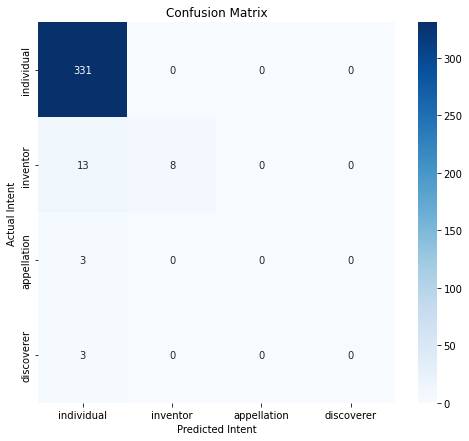

In [102]:
#person/Svm
c_type=df[df['CoarseType']=='person']
c_type= c_type[c_type['FineType'].isin(['individual','inventor','appellation','discoverer'])]
# person_model=fineModel(c_type,'svm')
person_model=kFoldFineModel(c_type,'person','svm')

['bank' 'sport-team' 'company']
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 12 13 14 15 16 17 18 19 21 22 23 24 25 26 27 28 30 31 32 33 34 36 37 38 39 40] VALIDATION: [ 4 11 20 29 35]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 20 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40] VALIDATION: [ 2 13 19 21]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 28 29 30 31 33 34 35 37 38 39 40] VALIDATION: [ 7 17 32 36]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 26 27 28 29 30 31 32 33 34 35 36 38] VALIDATION: [25 37 39 40]
TRAIN: [ 1  2  3  4  5  6  7  9 10 11 12 13 15 16 17 18 19 20 21 22 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40] VALIDATION: [ 0  8 14 23]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 32 34 35 36 37 38 39 40] VALIDATION: [ 9 15 31 33]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 17 19 20 21 22 23 24 25 26 27 28 29 31 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  UserWarning,


              precision    recall  f1-score   support

        bank       0.50      0.57      0.53         7
  sport-team       0.50      0.20      0.29         5
     company       0.75      1.00      0.86         6

    accuracy                           0.61        18
   macro avg       0.58      0.59      0.56        18
weighted avg       0.58      0.61      0.57        18



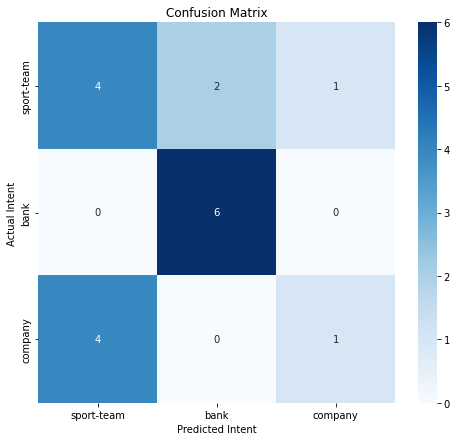

In [103]:
#organization/Svm
c_type=df[df['CoarseType']=='organization']
c_type= c_type[c_type['FineType'].isin(['sport-team','bank','company'])]
# organization_model=fineModel('person','svm')
organization_model=kFoldFineModel(c_type,'organization','svm')

['country' 'city' 'district' 'state' 'address' 'river' 'region']
TRAIN: [  0   1   2   3 ... 437 438 439 440] VALIDATION: [ 13  18  24  37  41  56  63  83  96 102 104 111 115 119 121 123 128 130 142 145 154 160 161 163 164 165 174 206 215
 228 232 234 277 332 363 365 369 374 379 383 384 387 392 406 421]
TRAIN: [  0   1   2   3 ... 437 438 439 440] VALIDATION: [  9  14  17  27  28  38  57  61  72  89  90  93 101 116 131 152 176 177 178 187 194 210 216 218 227 248 253 255 263
 271 275 278 302 306 307 309 316 326 330 335 337 348 359 431]
TRAIN: [  0   1   2   3 ... 437 438 439 440] VALIDATION: [  7  35  49  55  58  74  75  81  84  91 109 120 134 137 151 157 166 168 172 183 184 199 202 233 237 266 286 310 311
 312 320 325 336 343 351 358 372 380 388 396 408 411 425 432]
TRAIN: [  1   2   3   4 ... 437 438 439 440] VALIDATION: [  0  10  11  20  36  48  54  65  70  85  86  88  95  98 100 105 107 126 136 156 170 200 205 212 222 223 242 246 261
 273 289 298 300 314 323 346 347 357 395 397 403 

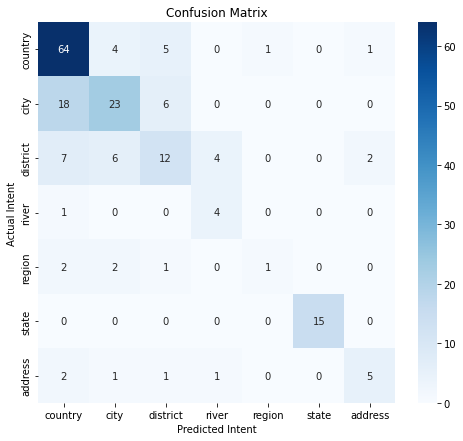

In [104]:
#location/Svm
c_type=df[df['CoarseType']=='location']
c_type= c_type[c_type['FineType'].isin(['country','city','district','river','region','state','address'])]
# location_model=fineModel(c_type,'svm')
location_model=kFoldFineModel(c_type,'location','svm')

['date' 'day' 'range' 'year' 'duration']
TRAIN: [  0   1   2   3 ... 696 697 700 702] VALIDATION: [ 21  26 117 119 ... 675 698 699 701]
TRAIN: [  0   1   2   3 ... 699 700 701 702] VALIDATION: [  4   6  37  45 ... 685 686 690 697]


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  UserWarning,


TRAIN: [  0   1   2   3 ... 699 700 701 702] VALIDATION: [ 12  25  49  56 ... 668 674 680 681]
TRAIN: [  0   1   2   3 ... 699 700 701 702] VALIDATION: [ 17  32  33  36 ... 644 653 654 696]
TRAIN: [  0   1   3   4 ... 699 700 701 702] VALIDATION: [  2  13  27  31 ... 645 647 664 682]
TRAIN: [  1   2   4   5 ... 699 700 701 702] VALIDATION: [  0   3  10  16 ... 655 665 673 687]
TRAIN: [  0   1   2   3 ... 698 699 700 701] VALIDATION: [  8  18  28  38 ... 662 670 688 702]
TRAIN: [  0   2   3   4 ... 698 699 701 702] VALIDATION: [  1  19  41  46 ... 663 677 693 700]
TRAIN: [  0   1   2   3 ... 699 700 701 702] VALIDATION: [  7  11  20  29 ... 676 689 691 692]
TRAIN: [  0   1   2   3 ... 699 700 701 702] VALIDATION: [  5   9  14  15 ... 642 658 694 695]
Validation Accuracy for each Iteration [0.943662 0.915493 0.915493 0.914286 0.942857 0.942857 0.942857 0.928571 0.957143 0.942857]
Mean accuracy for validation set:  0.9346076458752515
Std for accuracy:  0.014290531111874498
---------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


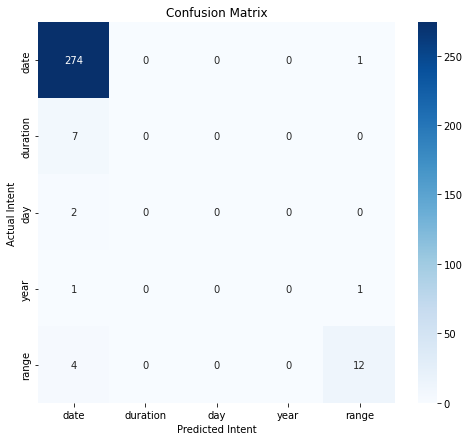

In [105]:
#temporal/Svm
c_type=df[df['CoarseType']=='temporal']
c_type= c_type[c_type['FineType'].isin(['date','duration','day','year','range'])]
# temporal_model=fineModel(c_type,'svm')
temporal_model=kFoldFineModel(c_type,'temporal','svm')

['rank' 'money' 'percentage' 'count' 'length' 'temperture']
TRAIN: [  0   1   2   3 ... 362 363 364 365] VALIDATION: [ 18  27  37  42  45  50  55  59  61  62  69  70  72  87  94 101 119 120 188 192 206 212 236 247 257 261 265 270 274
 284 311 315 316 319 322 350 366]
TRAIN: [  1   2   3   4 ... 360 362 363 366] VALIDATION: [  0   5   8  19  30  34  43  54  60  78  83  92  95  99 100 108 112 142 144 162 171 194 205 210 227 229 238 249 258
 279 281 340 355 356 361 364 365]
TRAIN: [  0   1   3   5 ... 363 364 365 366] VALIDATION: [  2   4  11  12  28  36  46  47  65  71  75  88 103 117 131 136 154 160 164 179 181 190 225 252 266 268 271 280 292
 298 307 320 323 333 341 351 352]
TRAIN: [  0   2   3   4 ... 363 364 365 366] VALIDATION: [  1   7  26  39  56  58  63  64  90  98 109 127 132 140 145 146 159 170 175 178 193 204 207 226 239 260 263 290 294
 295 302 303 331 335 345 346 360]
TRAIN: [  0   1   2   3 ... 363 364 365 366] VALIDATION: [  9  10  16  21  32  40  48  57  82  97 114 126 16

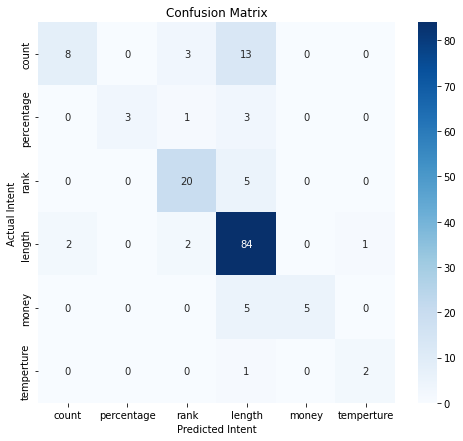

In [106]:
#numerical/Svm
c_type=df[df['CoarseType']=='numerical']
c_type= c_type[c_type['FineType'].isin(['count','percentage','rank','length','money','temperture'])]
# numerical_model=fineModel(c_type,'svm')
numerical_model=kFoldFineModel(c_type,'numerical','svm')

['description' 'method' 'reason']
TRAIN: [  0   1   2   3 ... 107 108 109 111] VALIDATION: [ 13  22  28  37  57  63  70  74  87  89  94 110]
TRAIN: [  2   3   4   5 ... 107 109 110 111] VALIDATION: [  0   1  10  25  26  40  42  50  66  67  77 108]
TRAIN: [  0   1   2   3 ... 107 108 110 111] VALIDATION: [  5  11  31  34  43  49  55  56  68 105 109]
TRAIN: [  0   1   3   4 ... 108 109 110 111] VALIDATION: [ 2 15 21 30 41 47 58 80 81 90 96]
TRAIN: [  0   1   2   3 ... 108 109 110 111] VALIDATION: [ 6  8 32 35 39 53 64 76 78 84 85]
TRAIN: [  0   1   2   3 ... 108 109 110 111] VALIDATION: [14 33 36 38 48 54 65 72 83 92 98]
TRAIN: [  0   1   2   3 ... 107 108 109 110] VALIDATION: [  4  20  23  44  46  62  71  93 101 104 111]
TRAIN: [  0   1   2   3 ... 108 109 110 111] VALIDATION: [  7   9  29  61  69  75  82  86  95 102 106]
TRAIN: [  0   1   2   4 ... 108 109 110 111] VALIDATION: [  3  12  17  19  24  51  59  88  91 100 107]
TRAIN: [  0   1   2   3 ... 108 109 110 111] VALIDATION: [ 16  1

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  UserWarning,


Test Accuracy : 0.9591836734693877
              precision    recall  f1-score   support

 description       0.98      0.98      0.98        45
      method       1.00      0.67      0.80         3
      reason       0.50      1.00      0.67         1

    accuracy                           0.96        49
   macro avg       0.83      0.88      0.81        49
weighted avg       0.97      0.96      0.96        49



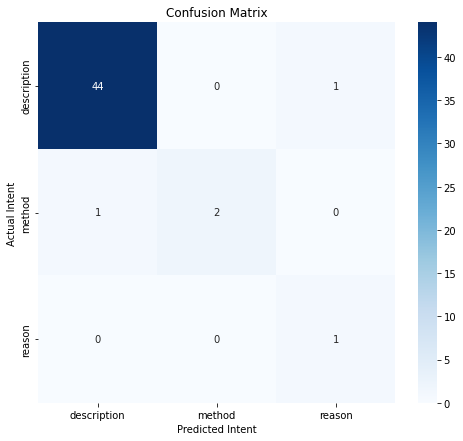

In [107]:
#explanation/Svm
c_type=df[df['CoarseType']=='explanation']
c_type= c_type[c_type['FineType'].isin(['description','method','reason'])]
# explanation_model=fineModel(c_type,'svm')
explanation_model=kFoldFineModel(c_type,'explanation','svm')

['material' 'animal' 'book' 'disease' 'color' 'language' 'device' 'sport' 'planet']
TRAIN: [  0   2   3   4 ... 145 146 147 148] VALIDATION: [  1  12  29  35  38  46  50  51  59  63  80  85 103 108 137]
TRAIN: [  0   1   3   5 ... 144 145 146 148] VALIDATION: [  2   4  16  41  53  69  81  89 101 120 122 127 131 138 147]


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  UserWarning,


TRAIN: [  1   2   3   4 ... 145 146 147 148] VALIDATION: [  0  10  11  21  40  42  67  84  93 107 113 124 132 133 139]
TRAIN: [  0   1   2   3 ... 145 146 147 148] VALIDATION: [  5  14  18  22  26  27  30  47  49  68  94  98 102 112 136]
TRAIN: [  0   1   2   3 ... 145 146 147 148] VALIDATION: [  6  15  34  43  44  55  56  57  66  71  78  79  88 128 142]
TRAIN: [  0   1   2   3 ... 145 146 147 148] VALIDATION: [ 28  31  64  72  73  77  82  90  96 110 119 125 129 134 143]
TRAIN: [  0   1   2   3 ... 145 146 147 148] VALIDATION: [  7  17  23  33  39  45  60  62  74  75  83 109 111 121 126]
TRAIN: [  0   1   2   3 ... 141 142 143 147] VALIDATION: [ 13  48  54  58  61  91 105 117 118 130 135 144 145 146 148]
TRAIN: [  0   1   2   4 ... 145 146 147 148] VALIDATION: [  3   8  20  36  65  76  86  92  95  97 100 104 106 116 140]
TRAIN: [  0   1   2   3 ... 145 146 147 148] VALIDATION: [  9  19  24  25  32  37  52  70  87  99 114 115 123 141]
Validation Accuracy for each Iteration [0.6      0.8

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


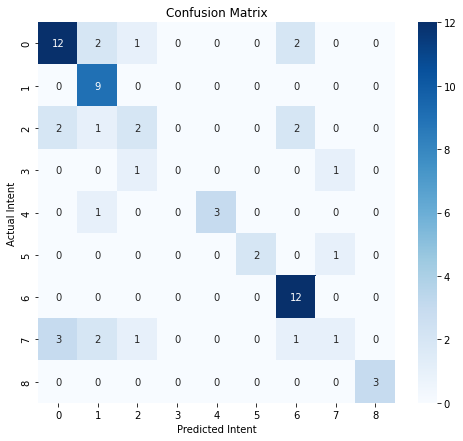

In [108]:
#miscelleneous/Svm
c_type=df[df['CoarseType']=='miscellaneous']
c_type= c_type[c_type['FineType'].isin(['material','animal','device','sport','book','planet','color','religon','disease','language'])]
# miscellaneous_model=fineModel(c_type,'svm')
miscellaneous_model=kFoldFineModel(c_type,'miscelleneous','svm')

**Overall Prediction**

In [110]:
unseen_questions=[["सन् २०२० मार्चमा प्रदान गरिएको इन्टरनेसनल कम्युनिकेसन अवार्ड बाट सम्मानित व्यत्तित्व को हनुहुन्छ ? "],["नेपाल न्यून आय भएका मुलुकबाट न्यून मध्यम आय भएका मुलुकको सूचीमा कहिले स्तरोन्नति भएको हो ? "],
                      ["वि.सं. २०७७ असार २३ सरकारले नेपाल प्रहरी महानिरीक्षक (आईजीपी) मा कसलाई नियुक्त गर्यो ?"],["हाल रेडियो नेपालबाट कति भाषामा समाचार प्रसारण हुने गर्छ ?"],
                      ["समाजसेवी तथा शिक्षाविद् अङ्गुरबाबा जोशीको निधन कहिले भएको हो ?"],["सन् २०२० जुनमा सुरक्षा परिषदको अस्थायी सदस्यमा निर्वाचित हुन सफल राष्ट्र कुन कुन हुन ?"],
                      ["'एक वडा एक व्यायामशाला' निमाणको योजना अघि बढाउने स्थानीय तह कुन हो ?"],["बालबालिकाको क्षेत्रमा काम गर्ने अन्तर्राष्ट्रिय संस्था किवानिज इन्टरनेसनलको एसिया प्यासिफिक सम्मेलन हालै कहाँ सम्पन्न भयो ?"],
                      ["लोकसेवा आयोग विधेयक प्रतिनिधिसभाबाट कहिले पारित भएको हो ?"],["नेपालमा कृषक परिचयपत्र वितरण गर्ने कार्य कुन जिल्लाबाट सुरु गरिएको हो ?"],
                      ["विश्व बैंकद्वारा विसं २०७६ कात्तिक ७ मा सार्वजनिक डुइङ बिजनेस प्रतिवेदन २०२० अनुसार नेपाल कतिऔं स्थानमा रहेको छ ?"],['नेपाली पोर्टको शुभारम्भ कहिले भएको हो ?'],
                      ["सन्  २०१९/२० को विस्डन क्रिकेटर अफ द इयरको उपाधि जित्ने क्रिकेटर को हुन ?"],['सबै जिल्लामा स्वास्थ्य विमा सेवा लागु गर्ने पहिलो प्रदेश कुन हो ?']]
dfq=pd.DataFrame(unseen_questions,columns=['questions'])

dfq['questions']= preprocessing(dfq['questions'])
validation_questions=dfq['questions'].to_numpy()


print("SVM Model")
for question in validation_questions:
  question=[question]
  # test_pred= svm_model.predict(question)
  test_pred= k_fold_svm_model.predict(question)
  coarse_type=test_pred[0]
  if(coarse_type=='person'):
    fine_type=person_model.predict(question)
  elif(coarse_type=='organization'):
    fine_type=organization_model.predict(question)
  elif(coarse_type=='location'):
    fine_type=location_model.predict(question)
  elif(coarse_type=='temporal'):
    fine_type=temporal_model.predict(question)
  elif(coarse_type=='numerical'):
    fine_type=numerical_model.predict(question)
  elif(coarse_type=='explanation'):
    fine_type=explanation_model.predict(question)
  elif(coarse_type=='miscellaneous'):
    fine_type=miscellaneous_model.predict(question)
  else:
    print("Coarse type didn't match")

  print(question[0] +" "+ coarse_type+ " : " +fine_type[0])
print('\n')

SVM Model
सन् २०२० मार्च प्रदान गरिएको इन्टरनेसनल कम्युन िक ेसन अवार्ड बाट सम्मानित व्य त्ति त्व को हन ुहुन्छ person : individual
नेपाल न्यून आय भएका मुलुक बाट मध्यम मुलुकको सूची कहिले स्तर ो न्न ति temporal : date
वि सं २०७७ असार २३ सरकार नेपाल प्रहरी महानिरीक्षक कस नियुक्त गर्यो person : individual
हाल रेडियो नेपाल बाट कति भाषामा समाचार प्रसारण numerical : count
समाजसेवी शिक्षा विद् अङ्ग ुर बाबा जोशी को निधन कहिले temporal : date
सन् २०२० सुरक्षा परिषद को अस्थायी सदस्य निर्वाचित सफल राष्ट्र कुन person : individual
ण को योजना अघि बढाउने स्थानीय तह कुन location : country
बालबालिका को क्षेत्रमा काम अन्तर्राष्ट्रिय संस्था वा निज इन्टरनेसनल एसिया प्यास िफ िक सम्मेलन हालै कहाँ सम्पन्न भयो temporal : date
लोक सेवा आयोग विधेयक प्रतिनिधिसभा बाट कहिले पारित temporal : date
नेपालमा कृषक परिचय पत्र वितरण कार्य कुन जिल्लाबाट सुरु गरिएको temporal : date
विश्व बैंक द्वारा विसं २०७६ कात्तिक ७ सार्वजनिक डु इ ङ बिज नेस प्रतिवेदन २०२० नेपाल कति स्थानमा numerical : rank
नेपाली पोर्ट को शुभ ारम्भ कहिले t